# Content

1. [Биномиальный критерий для доли](#Биномиальный-критерий-для-доли)
2. [Доверительные интервалы на основе bootstrap](#Доверительные-интервалы-на-основе-bootstrap)
3. [Chi2 - критерий](#Критерий-согласия-Пирсона)
4. [Доверительные интервалы для оценки среднего](#Доверительные-интервалы-для-оценки-среднего)
5. [Множественная проверка гипотез](#Множественная-проверка-гипотез)
6. [Доверительные интервалы для доли](#Доверительные-интервалы-для-доли)
7. [Критерии Стьюдента](#Критерии-Стьюдента)
8. [Доверительные интервалы для двух долей](#Доверительные-интервалы-для-двух-долей)
9. [Z-критерий для двух долей](#Z-критерий-для-двух-долей)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_score

import requests

from utils.download import download_file_from_google_drive

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Биномиальный критерий для доли


## Shaken, not stirred


Джеймс Бонд говорит, что предпочитает мартини взболтанным, но не смешанным. Проведём слепой тест (blind test): $n$ раз предложим ему пару напитков и выясним, какой из двух он предпочитает. Получаем: 
* **выборка:** бинарный вектор длины $n$, где 1 — Джеймс Бонд предпочел взболтанный напиток, 0 — смешанный;
* **гипотеза $H_0$:** Джеймс Бонд не различает 2 вида напитков и выбирает наугад;
* **статистика $T$:** количество единиц в выборке.

Если нулевая гипотеза справедлива и Джеймс Бонд действительно выбирает наугад, то мы можем с одинаковой вероятностью получить любой из $2^n$ бинарных векторов длины $n$. 

Мы могли бы перебрать все такие векторы, посчитать на каждом значение статистики $T$ и получить таким образом её нулевое распределение. Но в данном случае этот этап можно пропустить: мы имеем дело с выборкой, состоящей из 0 и 1, то есть, из распределения Бернулли $Ber(p)$. Нулевая гипотеза выбора наугад соответствует значению $p=\frac1{2}$, то есть, в каждом эксперименте вероятность выбора взболтанного мартини равна $\frac1{2}$. Сумма $n$ одинаково распределённых бернуллиевских случайных величин с параметром $p$ имеет биномиальное распределение $Bin(n, p)$. Следовательно, нулевое распределение статистики $T$ — $Bin\left(n, \frac1{2}\right)$.

Пусть $n=16.$

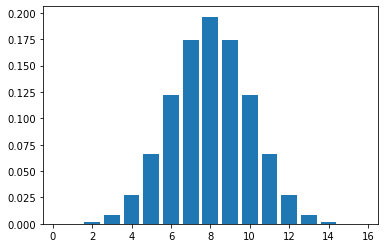

In [2]:
n = 16
F_H0 = stats.binom(n, 0.5)

x = np.linspace(0,16,17)

pylab.bar(x, F_H0.pmf(x), align = 'center')
xlim(-0.5, 16.5) 
pylab.show()

## Односторонняя альтернатива

**гипотеза $H_1$:** Джеймс Бонд предпочитает взболтанный мартини.

При такой альтернативе более вероятны большие значения статистики; при расчёте достигаемого уровня значимости будем суммировать высоту столбиков в правом хвосте распределения.

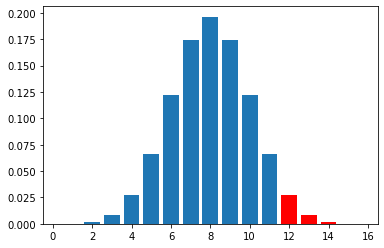

0.0384063720703125


In [3]:
pylab.bar(x, F_H0.pmf(x), align = 'center')
pylab.bar(np.linspace(12,16,5), F_H0.pmf(np.linspace(12,16,5)), align = 'center', color='red')
xlim(-0.5, 16.5) 
pylab.show()

print(stats.binom_test(12, 16, 0.5, alternative = 'greater'))

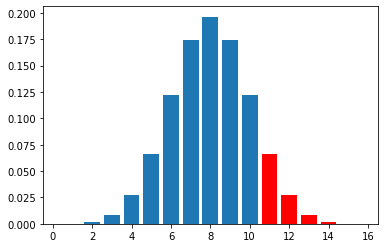

0.10505676269531246


In [4]:
pylab.bar(x, F_H0.pmf(x), align = 'center')
pylab.bar(np.linspace(11,16,6), F_H0.pmf(np.linspace(11,16,6)), align = 'center', color='red')
xlim(-0.5, 16.5) 
pylab.show()

print(stats.binom_test(11, 16, 0.5, alternative = 'greater'))

## Двусторонняя альтернатива

**гипотеза $H_1$:** Джеймс Бонд предпочитает какой-то определённый вид мартини.

При такой альтернативе более вероятны очень большие и очень маленькие значения статистики; при расчёте достигаемого уровня значимости будем суммировать высоту столбиков в правом и левом хвостах распределения.

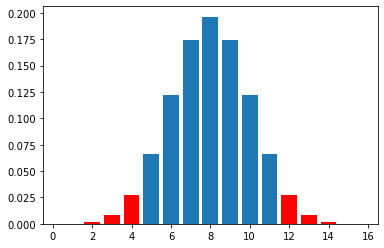

0.076812744140625


In [5]:
pylab.bar(x, F_H0.pmf(x), align = 'center')
pylab.bar(np.linspace(12,16,5), F_H0.pmf(np.linspace(12,16,5)), align = 'center', color='red')
pylab.bar(np.linspace(0,4,5), F_H0.pmf(np.linspace(0,4,5)), align = 'center', color='red')
xlim(-0.5, 16.5) 
pylab.show()

print(stats.binom_test(12, 16, 0.5, alternative = 'two-sided'))

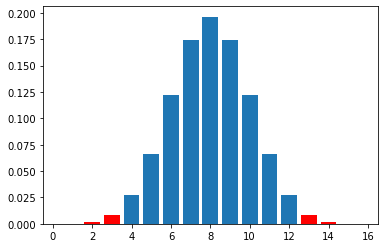

0.021270751953125


In [6]:
pylab.bar(x, F_H0.pmf(x), align = 'center')
pylab.bar(np.linspace(13,16,4), F_H0.pmf(np.linspace(13,16,4)), align = 'center', color='red')
pylab.bar(np.linspace(0,3,4), F_H0.pmf(np.linspace(0,3,4)), align = 'center', color='red')
xlim(-0.5, 16.5) 
pylab.show()

print(stats.binom_test(13, 16, 0.5, alternative = 'two-sided'))

# Доверительные интервалы на основе bootstrap

### Время ремонта телекоммуникаций

Verizon — основная региональная телекоммуникационная компания (Incumbent Local Exchange Carrier, ILEC) в западной 
части США. В связи с этим данная компания обязана предоставлять сервис ремонта телекоммуникационного оборудования 
не только для своих клиентов, но и для клиентов других локальных телекоммуникационых компаний (Competing Local Exchange Carriers, CLEC). При этом в случаях, когда время ремонта оборудования для клиентов других компаний существенно выше, чем для собственных, Verizon может быть оштрафована. 

In [2]:
file_id = '1sI8v6gu1sbSUs91ItvMZ2gbaxyJrsQvU'
destination = 'verizon.txt'
download_file_from_google_drive(file_id, destination)

In [3]:
data = pd.read_csv('data/verizon.txt', sep='\t')
print("Shape: {}".format(data.shape))

data.head()

Shape: (1687, 2)


,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


In [18]:
data.Group.value_counts()

ILEC    1664
CLEC      23
Name: Group, dtype: int64

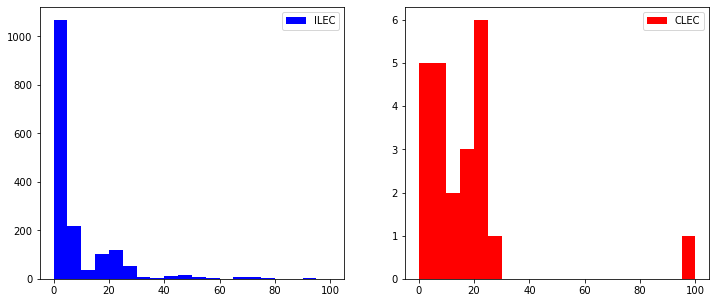

In [19]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.Group == 'ILEC'].Time, bins = 20, color = 'b', range = (0, 100), label = 'ILEC')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.Group == 'CLEC'].Time, bins = 20, color = 'r', range = (0, 100), label = 'CLEC')
pylab.legend()

pylab.show()

## Bootstrap

In [21]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [36]:
ilec_time = data[data.Group == 'ILEC'].Time.values
clec_time = data[data.Group == 'CLEC'].Time.values

np.random.seed(0)

# Интервальная оценка медианы

ilec_median_scores = list(map(np.median, get_bootstrap_samples(ilec_time, 1000)))
clec_median_scores = list(map(np.median, get_bootstrap_samples(clec_time, 1000)))

print("95% confidence interval for the ILEC median repair time:",  stat_intervals(ilec_median_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  stat_intervals(clec_median_scores, 0.05))

# Точечная оценка разности медиан

print("difference between medians:", np.median(clec_time) - np.median(ilec_time))

# Интервальная оценка разности медиан

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(ilec_median_scores, clec_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [3.18    3.82525]
95% confidence interval for the CLEC median repair time: [ 5.79125 20.     ]
difference between medians: 10.74
95% confidence interval for the difference between medians [ 2.04975 16.63   ]


# Критерий согласия Пирсона 

## Исчерпанная рождаемость

Исчерпанная рождаемость — количество детей, родившихся у женщины на момент окончания конвенционального репродуктивного возраста (45 лет). Для 1878 женщин старше 45, участвовавших в социологическом опросе жителей Швейцарии, известно количество детей. Этот признак — типичный счётчик, а, значит, его можно попробовать описать распределением Пуассона.

* **выборка** - целочисленный вектор длиы $n$, характеризующий количество детей у опрашиваемой женщины
* **гипотеза $H_0$** - рассматриваемая величина имеет распределение Пуассона

In [39]:
file_id = '1K1O0C8T1O3xkjzxTeQOyOCZEyCwt94UF'
destination = 'fertility.txt'
download_file_from_google_drive(file_id, destination)

In [42]:
fin = open('data/fertility.txt', 'r')
data = list(map(lambda x: int(x.strip()), fin.readlines()))

In [43]:
data[:20]

[0, 0, 2, 0, 2, 3, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 3, 2, 2, 4]

1.93716719914803

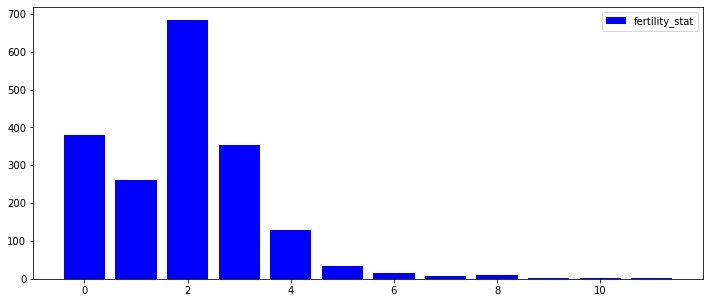

In [44]:
pylab.bar(range(12), np.bincount(data), color = 'b', label = 'fertility_stat')
pylab.legend()

l = np.mean(data)
l

## Критерий согласия

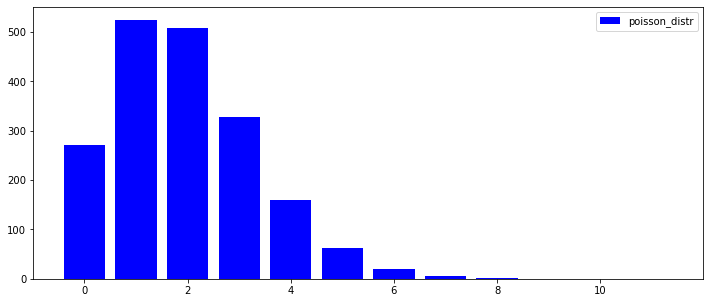

In [45]:
observed_frequences = np.bincount(data)

expected_frequences = [len(data)*stats.poisson.pmf(x, l) for x in range(min(data), max(data) + 1)]

pylab.bar(range(len(expected_frequences)), expected_frequences, color = 'b', label = 'poisson_distr')
pylab.legend()

Статистика критерия хи-квадрат: $$\chi^2=\sum_{i=1}^K \frac{\left(n_i- np_i\right)^2}{np_i}$$
При справедливости нулевой гипотезы имеет распределение хи-квадрат с числом степеней свободы $K-1-m$, где $m$ - число параметров распределения, оцененных по выборке.

In [46]:
stats.chisquare(observed_frequences, expected_frequences, ddof = 1)

Power_divergenceResult(statistic=431.5752205284916, pvalue=1.772613180233512e-86)

# Доверительные интервалы для оценки среднего

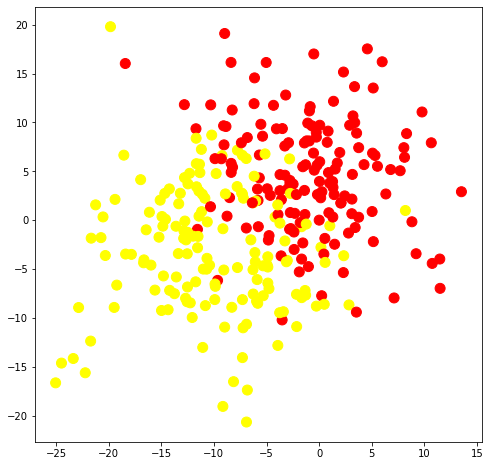

In [52]:
blobs = datasets.make_blobs(300, centers = 2, cluster_std = 6, random_state=1)

pylab.figure(figsize(8, 8))
pylab.scatter(list(map(lambda x: x[0], blobs[0])), list(map(lambda x: x[1], blobs[0])), c = blobs[1], cmap = 'autumn',
             s=100)

In [61]:
train_data, test_data, train_labels, test_labels = train_test_split(blobs[0], blobs[1], 
                                                                                    test_size = 15,
                                                                                    random_state = 1)

# Точечная оценка
print('--------Точечная оценка--------\n')
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(train_data, train_labels)
print('Ridge classifier score: ', metrics.roc_auc_score(test_labels, ridge_model.predict(test_data)))


sgd_model = linear_model.SGDClassifier(random_state = 0)
sgd_model.fit(train_data, train_labels)
print('SGD classifier score: ', metrics.roc_auc_score(test_labels, sgd_model.predict(test_data)), '\n')

print('----Точечная оценка среднего----\n')

sgd_auc_scores = cross_val_score(linear_model.SGDClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

ridge_auc_scores = cross_val_score(linear_model.RidgeClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

print("sgd model auc: mean %.3f, std %.3f" % (sgd_auc_scores.mean(), sgd_auc_scores.std(ddof=1)))
print("ridge model auc: mean %.3f, std %.3f" % (ridge_auc_scores.mean(), ridge_auc_scores.std(ddof=1)))

--------Точечная оценка--------

Ridge classifier score:  0.8888888888888888
SGD classifier score:  0.7777777777777778 

----Точечная оценка среднего----

sgd model auc: mean 0.887, std 0.102
ridge model auc: mean 0.937, std 0.071


In [63]:
print('----Интервальная оценка среднего----\n')

from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

sgd_mean = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()

print('----z interval \n')

print("sgd model mean auc 95%% confidence interval", _zconfint_generic(sgd_mean, 
                                                                  sqrt(0.25/len(sgd_auc_scores)), 
                                                                  0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _zconfint_generic(ridge_mean, 
                                                                    sqrt(0.25/len(sgd_auc_scores)), 
                                                                    0.05, 'two-sided'))

print('\n----t interval \n')

sgd_mean_std = sgd_auc_scores.std(ddof=1)/sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1)/sqrt(len(ridge_auc_scores))

print("sgd model mean auc 95%% confidence interval", _tconfint_generic(sgd_mean, sgd_mean_std,
                                                                       len(sgd_auc_scores) - 1,
                                                                       0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _tconfint_generic(ridge_mean, ridge_mean_std,
                                                                         len(sgd_auc_scores) - 1,
                                                                         0.05, 'two-sided'))

----Интервальная оценка среднего----

----z interval 

sgd model mean auc 95%% confidence interval (0.6683693648558544, 1.1066306351441453)
ridge model mean auc 95%% confidence interval (0.7174765077129974, 1.155737778001288)

----t interval 

sgd model mean auc 95%% confidence interval (0.8398284915206542, 0.9351715084793455)
ridge model mean auc 95%% confidence interval (0.903235324375978, 0.9699789613383075)


#### z-интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

#### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

# Множественная проверка гипотез

In [64]:
from scipy.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests 

In [68]:
file_id = '1ikPNxBiBDGdCk3xsw0yIjtNBqU8v5h3f'
destination = 'foodmart.sales.tsv'
download_file_from_google_drive(file_id, destination)

sales = pd.read_csv('data/foodmart.sales.tsv', sep = '\t', header = 0, parse_dates = [2])
sales.head()

,product_id,store_id,date,sales
0,4,6,1997-01-01,4
1,25,6,1997-01-01,3
2,48,6,1997-01-01,3
3,76,6,1997-01-01,4
4,119,6,1997-01-01,3


In [69]:
file_id = '1hkWX52Oe2iAr6wOWuIJbNUDzn0Boc3uQ'
destination = 'foodmart.products.tsv'
download_file_from_google_drive(file_id, destination)

products = pd.read_csv('data/foodmart.products.tsv', sep = '\t', header = 0)
products.head()

,product_class_id,product_id,brand_name,product_name,SKU,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,cases_per_pallet,shelf_width,shelf_height,shelf_depth
0,30,1,Washington,Washington Berry Juice,90748583674,2.85,8.39,6.39,False,False,30,14,16.9,12.60,7.40
1,52,2,Washington,Washington Mango Drink,96516502499,0.74,7.42,4.42,False,True,18,8,13.4,3.71,22.60
2,52,3,Washington,Washington Strawberry Drink,58427771925,0.83,13.10,11.10,True,True,17,13,14.4,11.00,7.77
3,19,4,Washington,Washington Cream Soda,64412155747,3.64,10.60,9.60,True,False,26,10,22.9,18.90,7.93
4,19,5,Washington,Washington Diet Soda,85561191439,2.19,6.66,4.65,True,False,7,10,20.7,21.90,19.20


In [70]:
sales = sales.merge(products[['product_id', 'product_name']], 
                    on = ['product_id'], how = 'inner')
sales.head()

,product_id,store_id,date,sales,product_name
0,4,6,1997-01-01,4,Washington Cream Soda
1,4,7,1997-01-05,3,Washington Cream Soda
2,4,6,1997-01-06,2,Washington Cream Soda
3,4,17,1997-01-11,2,Washington Cream Soda
4,4,24,1997-01-11,2,Washington Cream Soda


## Корреляция Пирсона

In [71]:
sparse_sales = pd.pivot_table(sales, values='sales', index=['date', 'store_id'],
                     columns=['product_name'], fill_value = 0)
sparse_sales.head()

product_name         ADJ Rosy Sunglasses  Akron City Map  \
date       store_id                                        
1997-01-01 6                           0               0   
           14                          0               0   
1997-01-02 11                          0               0   
           23                          0               0   
1997-01-03 7                           0               0   

product_name         Akron Eyeglass Screwdriver  American Beef Bologna  \
date       store_id                                                      
1997-01-01 6                                  0                      0   
           14                                 0                      0   
1997-01-02 11                                 0                      0   
           23                                 0                      0   
1997-01-03 7                                  0                      0   

product_name         American Chicken Hot Dogs  American Cole Slaw  \
date       store_id                                                  
1997-01-01 6                                 0                   0   
           14                                0                   0   
1997-01-02 11                                0                   0   
           23                                0                   0   
1997-01-03 7                                 0                   0   

product_name         American Corned Beef  American Foot-Long Hot Dogs  \
date       store_id                                                      
1997-01-01 6                            0                            0   
           14                           0                            0   
1997-01-02 11                           0                            0   
           23                           0                            0   
1997-01-03 7                            0                            0   

product_name         American Low Fat Bologna  American Low Fat Cole Slaw  \
date       store_id                                                         
1997-01-01 6                                0                           0   
           14                               0                           0   
1997-01-02 11                               0                           0   
           23                               0                           0   
1997-01-03 7                                0                           0   

product_name         ...  Washington Apple Juice  Washington Berry Juice  \
date       store_id  ...                                                   
1997-01-01 6         ...                       0                       0   
           14        ...                       0                       0   
1997-01-02 11        ...                       0                       0   
           23        ...                       0                       0   
1997-01-03 7         ...                       0                       4   

product_name         Washington Cola  Washington Cranberry Juice  \
date       store_id                                                
1997-01-01 6                       0                           0   
           14                      0                           0   
1997-01-02 11                      0                           0   
           23                      0                           0   
1997-01-03 7                       0                           0   

product_name         Washington Cream Soda  Washington Diet Cola  \
date       store_id                                                
1997-01-01 6                             4                     0   
           14                            0                     0   
1997-01-02 11                            0                     0   
           23                            0                     0   
1997-01-03 7                             0                     0   

product_name         Wa

In [72]:
%%time 
corr_data = []

for i, lhs_column in enumerate(sparse_sales.columns):
    for j, rhs_column in enumerate(sparse_sales.columns):
        if i >= j:
            continue
        
        corr, p = pearsonr(sparse_sales[lhs_column], sparse_sales[rhs_column])
        corr_data.append([lhs_column, rhs_column, corr, p])

Wall time: 1min 33s


In [74]:
sales_correlation = pd.DataFrame.from_records(corr_data)
sales_correlation.columns = ['product_A', 'product_B', 'corr', 'p']
print('Сколько гипотез об отсутствии корреляции отвергается без поправки на множественную проверку? \n',
      (sales_correlation.p < 0.05).value_counts())


Сколько гипотез об отсутствии корреляции отвергается без поправки на множественную проверку? 
 False    982453
True     232008
Name: p, dtype: int64


## Поправка на множественную проверку

### Метод Холма

In [75]:
reject, p_corrected, a1, a2 = multipletests(sales_correlation.p, 
                                            alpha = 0.05, 
                                            method = 'holm') 

sales_correlation['p_corrected'] = p_corrected
sales_correlation['reject'] = reject

sales_correlation.reject.value_counts()

False    1212733
True        1728
Name: reject, dtype: int64

In [76]:
sales_correlation[sales_correlation.reject == True].sort_values(by='corr', ascending=False)

,product_A,product_B,corr,p,p_corrected,reject
1063670,Just Right Vegetable Soup,Plato French Roast Coffee,0.340598,1.226033e-22,1.488970e-16,True
885574,Great Muffins,Nationeel Grape Fruit Roll,0.322176,2.688803e-20,3.265443e-14,True
473067,Club Low Fat Cottage Cheese,Skinner Strawberry Drink,0.306701,1.883995e-18,2.288034e-12,True
1181001,Robust Monthly Home Magazine,Tri-State Lemons,0.303269,4.674973e-18,5.677558e-12,True
1160248,Pleasant Regular Ramen Soup,Shady Lake Ravioli,0.298502,1.619119e-17,1.966350e-11,True
...,...,...,...,...,...,...
662127,Ebony Potatos,Just Right Fancy Canned Anchovies,0.194914,4.073740e-08,4.940380e-02,True
565740,Cutting Edge Cole Slaw,Horatio Potato Chips,0.194875,4.099170e-08,4.971215e-02,True
615865,Discover Ravioli,High Quality Soft Napkins,0.194869,4.103075e-08,4.975947e-02,True
559150,Cormorant Toilet Bowl Cleaner,Plato Chunky Peanut Butter,0.194863,4.107241e-08,4.980995e-02,True


### Метод Бенджамини-Хохберга

In [77]:
reject, p_corrected, a1, a2 = multipletests(sales_correlation.p, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh') 
sales_correlation['p_corrected'] = p_corrected
sales_correlation['reject'] = reject

sales_correlation.reject.value_counts()

False    1138407
True       76054
Name: reject, dtype: int64

# Непараметрические критерии

16 лабораторных мышей были помещены в двухкомнатные клетки, в одной из комнат висело зеркало. С целью установить, есть ли у мышей какие-то предпочтения насчет зеркал, измерялась доля времени, которое каждая мышь проводила в каждой из своих двух клеток.

In [78]:
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

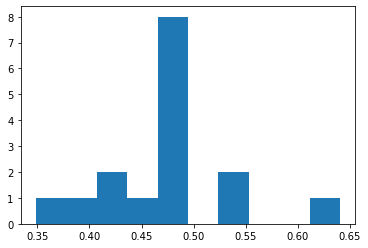

95% confidence interval for the mean time: [0.442918, 0.507660]


In [79]:
file_id = '1yr0PKR5k7nryYENYLYQoEETFZY4YQxjO'
destination = 'mirror_mouses.txt'
download_file_from_google_drive(file_id, destination)


mouses_data = pd.read_csv('data/mirror_mouses.txt', header = None)
mouses_data.columns = ['proportion_of_time']

pylab.hist(mouses_data.proportion_of_time)
pylab.show()

print('95%% confidence interval for the mean time: [%f, %f]' % zconfint(mouses_data))

### Критерий знаков

$H_0\colon$ медиана доли времени, проведенного в клетке с зеркалом, равна 0.5

$H_1\colon$ медиана доли времени, проведенного в клетке с зеркалом, не равна 0.5

In [80]:
print("M: %d, p-value: %f" % sign_test(mouses_data, 0.5))

M: -5, p-value: 0.021271


### Критерий знаковых рангов Вилкоксона

In [81]:
m0 = 0.5
stats.wilcoxon(mouses_data.proportion_of_time - m0)

WilcoxonResult(statistic=35.0, pvalue=0.09344482421875)

### Перестановочный критерий

$H_0\colon$ среднее равно 0.5

$H_1\colon$ среднее не равно 0.5

In [83]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(list(map(lambda x: x - mean, sample)))
    return t_stat

permutation_t_stat_1sample(mouses_data.proportion_of_time, 0.5)

-0.3953776999999997

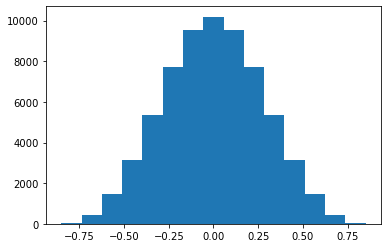

In [85]:
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = list(map(lambda x: x - mean, sample))
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

pylab.hist(permutation_zero_distr_1sample(mouses_data.proportion_of_time, 0.5), bins = 15)
pylab.show()

In [86]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    
print("p-value: %f" % permutation_test(mouses_data.proportion_of_time, 0.5))
print("p-value: %f" % permutation_test(mouses_data.proportion_of_time, 0.5, 10000))

p-value: 0.157776
p-value: 0.153449


## Недвижимость в Сиэттле

Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002. Изменились ли в среднем цены?

In [87]:
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

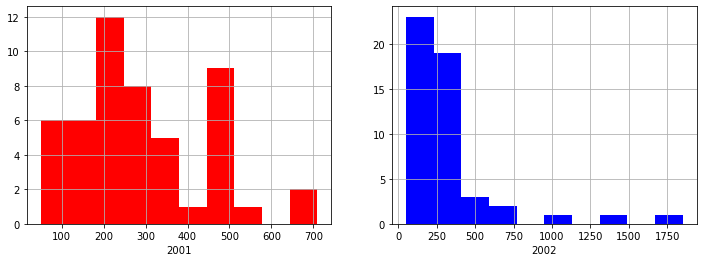

In [89]:
file_id = '1Q-QSHdNvAiNBIAk2n4foRuSz1r0Ku_9r'
destination = 'seattle.txt'
download_file_from_google_drive(file_id, destination)

seattle_data = pd.read_csv('data/seattle.txt', sep = '\t', header = 0)

price2001 = seattle_data[seattle_data['Year']  == 2001].Price
price2002 = seattle_data[seattle_data['Year']  == 2002].Price

pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(price2001, color = 'r')
pylab.xlabel('2001')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(price2002, color = 'b')
pylab.xlabel('2002')

pylab.show()

## Двухвыборочные критерии для независимых выборок

In [90]:
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2001))
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2002))

95% confidence interval for the mean: [245.193581, 332.659499]
95% confidence interval for the mean: [241.437946, 417.076334]


### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [91]:
stats.mannwhitneyu(price2001, price2002)

MannwhitneyuResult(statistic=1204.5, pvalue=0.3781936337850874)

### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

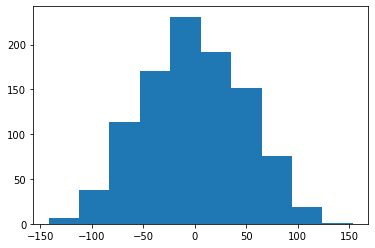

In [93]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

pylab.hist(permutation_zero_dist_ind(price2001, price2002, max_combinations = 1000))
pylab.show()

In [94]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    
print("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 10000))
print("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 50000))

p-value: 0.443900
p-value: 0.442280


## Терапия при анорексии

В исследовании оценивается эффективность поведенческой терапии для лечения анорексии. Для 50 пациентов известен вес до начала терапии и по её окончании. Была ли терапия эффективной?

In [95]:
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

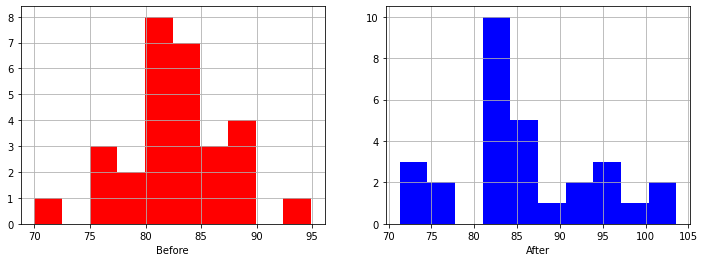

In [96]:
file_id = '16TmPiGTda3zv192457qzW4y5Qgv2ZoFS'
destination = 'weight.txt'
download_file_from_google_drive(file_id, destination)

weight_data = pd.read_csv('data/weight.txt', sep = '\t', header = 0)

pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(weight_data.Before, color = 'r')
pylab.xlabel('Before')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(weight_data.After, color = 'b')
pylab.xlabel('After')

pylab.show()

## Двухвыборочные критерии для связных выборок

$H_0\colon$ медианы веса до и после терапии совпадает

$H_1\colon$ медианы веса до и после тепрапии отличаются

95% confidence interval for mean weight before therapy: [80.926107, 84.453203]
95% confidence interval for mean weight after therapy: [82.656817, 88.736286]


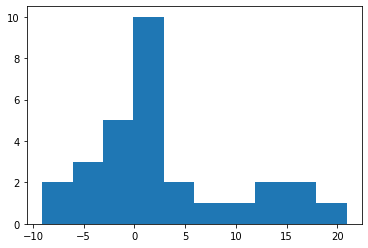

In [97]:
print('95%% confidence interval for mean weight before therapy: [%f, %f]' % zconfint(weight_data.Before))
print('95%% confidence interval for mean weight after therapy: [%f, %f]' % zconfint(weight_data.After))

pylab.hist(weight_data.After - weight_data.Before)
pylab.show()

### Критерий знаков

$H_0\colon P\left(X_1>X_2\right)=\frac1{2},$

$H_1\colon P\left(X_1>X_2\right)\neq\frac1{2}$

In [98]:
print("M: %d, p-value: %f" % sign_test(weight_data.After - weight_data.Before))

M: 3, p-value: 0.264931


### Критерий знаковых рангов Уилкоксона

$H_0\colon med\left(X_1-X_2\right)=0,$

$H_1\colon med\left(X_1-X_2\right)\neq0$

In [99]:
print(stats.wilcoxon(weight_data.After, weight_data.Before))
print(stats.wilcoxon(weight_data.After - weight_data.Before))

WilcoxonResult(statistic=131.5, pvalue=0.06291972262602667)
WilcoxonResult(statistic=131.5, pvalue=0.06291972262602667)


### Перестановочный критерий

$H_0\colon \mathbb{E}(X_1 - X_2) = 0$

$H_1\colon \mathbb{E}(X_1 - X_2) \neq 0$

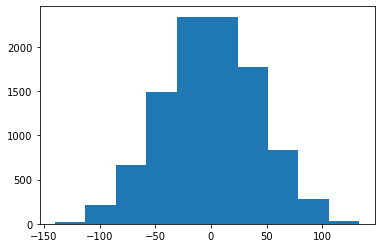

In [101]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(list(map(lambda x: x - mean, sample)))
    return t_stat

def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = list(map(lambda x: x - mean, sample))
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

pylab.hist(permutation_zero_distr_1sample(weight_data.After - weight_data.Before, 0., 
                               max_permutations = 10000))
pylab.show()

In [102]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    
print("p-value: %f" % permutation_test(weight_data.After - weight_data.Before, 0., 
                               max_permutations = 1000))
print("p-value: %f" % permutation_test(weight_data.After - weight_data.Before, 0., 
                               max_permutations = 50000))

p-value: 0.036000
p-value: 0.033040


# Доверительные интервалы для доли 

In [104]:
np.random.seed(1)

statistical_population = np.random.randint(2, size = 100000) 
random_sample = np.random.choice(statistical_population, size = 1000)

print('Истинное значение доли', statistical_population.mean())
print('Точечная оценка для доли: ', random_sample.mean())

Истинное значение доли 0.49771
Точечная оценка для доли:  0.502


### Доверительный интервал на основе нормального распределения

$$\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}$$

In [105]:
from statsmodels.stats.proportion import proportion_confint

normal_interval = proportion_confint(sum(random_sample), len(random_sample), method = 'normal')

print('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1], 
                                                  normal_interval[1] - normal_interval[0]))

normal_interval [0.471010, 0.532990] with width 0.061979


### Доверительный интервал Уилсона

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [106]:
wilson_interval = proportion_confint(sum(random_sample), len(random_sample), method = 'wilson')

print('wilson_interval [%f, %f] with width %f' % (wilson_interval[0],
                                                  wilson_interval[1],
                                                  wilson_interval[1] - wilson_interval[0]))

wilson_interval [0.471062, 0.532922] with width 0.061860


## Размер выборки для интервала заданной ширины

In [107]:
from statsmodels.stats.proportion import samplesize_confint_proportion
n_samples = int(np.ceil(samplesize_confint_proportion(random_sample.mean(), 0.01)))
print(n_samples)

np.random.seed(1)
random_sample = np.random.choice(statistical_population, size = n_samples)

normal_interval = proportion_confint(sum(random_sample), len(random_sample), method = 'normal')

print('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1],
                                                  normal_interval[1] - normal_interval[0]))

9604
normal_interval [0.481776, 0.501773] with width 0.019997


# Критерии Стьюдента

В рамках исследования эффективности препарата метилфенидат 24 пациента с синдромом дефицита внимания и гиперактивности в течение недели принимали либо метилфенидат, либо плацебо. В конце недели каждый пациент проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, и после недельного курса каждый испытуемые проходили второй тест.

Требуется оценить эффект применения препарата.

Pearson D.A, Santos C.W., Casat C.D., et al. (2004). Treatment effects of methylphenidate on cognitive functioning in children with mental retardation and ADHD. Journal of the American Academy of Child and Adolescent Psychiatry, 43(6), 677–685.

In [108]:
from statsmodels.stats.weightstats import *

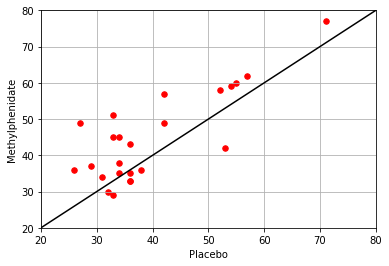

In [109]:
file_id = '1qnmNfuuNA6pi6d5E4miMsr-vJDLUIxn7'
destination = 'ADHD.txt'
download_file_from_google_drive(file_id, destination)

data = pd.read_csv('data/ADHD.txt', sep = ' ', header = 0)
data.columns = ['Placebo', 'Methylphenidate']

data.plot.scatter('Placebo', 'Methylphenidate', c = 'r', s = 30)
pylab.grid()
pylab.plot(range(100), c = 'black')
pylab.xlim((20, 80))
pylab.ylim((20, 80))
pylab.show()

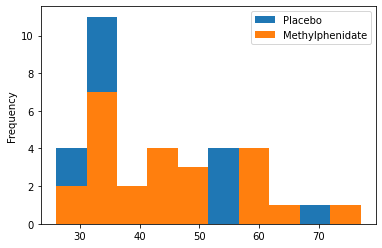

In [110]:
data.plot.hist()
pylab.show()

## Одновыборочный критерий Стьюдента

Исходя из того, что способность к подавлению испульсивных поведенческих реакций измеряется по шкале [0, 100], можно предположить, что при хорошей калибровке теста средняя способоность к подавлению реакций в популяции составляет 50. Тогда для того, чтобы проверить гипотезу о том, что пациенты в выборке действительно в среднем хуже справляются с подавлением импульсивных реакций (нуждаются в лечении), давайте проверим, что их способность к подавлению реакций отличается от средней (не равна 50). 

$H_0\colon$ среднее значение способности к подавлению испульсивных поведенческих реакций равно 50.

$H_1\colon$ не равно.

In [112]:
print(stats.ttest_1samp(data.Placebo, 50.0))
print("95%% confidence interval: [%f, %f]" % zconfint(data.Placebo))

Ttest_1sampResult(statistic=-4.438003341905128, pvalue=0.00018894293251080175)
95% confidence interval: [35.223273, 44.276727]


## Двухвыборочный критерий Стьюдента (независимые выборки)

Для того, чтобы использовать двухвыборочный критерий Стьюдента, убедимся, что распределения в выборках существенно не отличаются от нормальных.

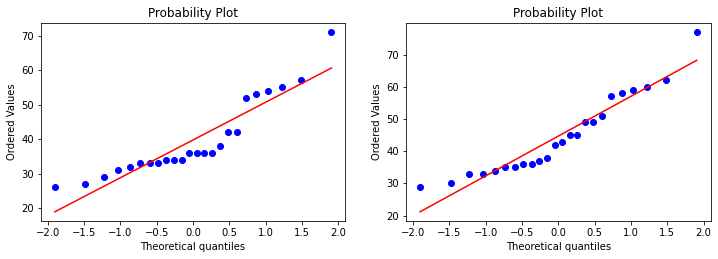

In [113]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data.Placebo, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data.Methylphenidate, dist="norm", plot=pylab)
pylab.show()

Критерий Шапиро-Уилка:

 $H_0\colon$ способности к подавлению импульсивных реакций распредлены нормально
 
 $H_1\colon$ не нормально.

In [114]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data.Placebo))
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data.Methylphenidate))

Shapiro-Wilk normality test, W-statistic: 0.857487, p-value: 0.003020
Shapiro-Wilk normality test, W-statistic: 0.916445, p-value: 0.048768


С помощью критерия Стьюдента проверим гипотезу о развенстве средних двух выборок.

Критерий Стьюдента:

$H_0\colon$ средние значения способности к подавлению испульсивных поведенческих реакций одинаковы для пациентов, принимавших препарат, и для пациентов, принимавших плацебо.

$H_0\colon$ не одинаковы.

In [116]:
print(stats.ttest_ind(data.Placebo, data.Methylphenidate, equal_var = False))
cm = CompareMeans(DescrStatsW(data.Methylphenidate), DescrStatsW(data.Placebo))
print("95%% confidence interval: [%f, %f]" % cm.tconfint_diff(usevar='unequal'))

Ttest_indResult(statistic=-1.4521635018159091, pvalue=0.1532919977404709)
95% confidence interval: [-1.915927, 11.832593]


## Двухвыборочный критерий Стьюдента (зависмые выборки)

Для того, чтобы использовать критерй Стьюдента для связанных выборок, давайте проверим, что распределение попарных разностей существенно не отличается от нормального.

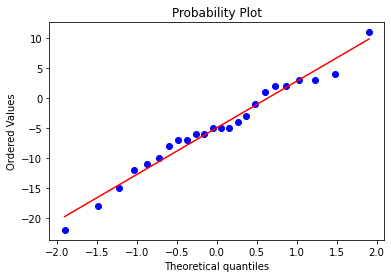

In [117]:
stats.probplot(data.Placebo - data.Methylphenidate, dist = "norm", plot = pylab)
pylab.show()

Критерий Шапиро-Уилка:

$H_0\colon$ попарные разности распределены нормально.

$H_1\colon$ не нормально.

In [118]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data.Methylphenidate - data.Placebo))

Shapiro-Wilk normality test, W-statistic: 0.979806, p-value: 0.892254


Критерий Стьюдента:

$H_0\colon$ средние значения способности к подавлению испульсивных поведенческих реакций одинаковы для пациентов, принимавших препарат, и для пациентов, принимавших плацебо.

$H_1\colon$ не одинаковы.

In [119]:
print(stats.ttest_rel(data.Methylphenidate, data.Placebo))
print("95%% confidence interval: [%f, %f]" % DescrStatsW(data.Methylphenidate - data.Placebo).tconfint_mean())

Ttest_relResult(statistic=3.2223624451230406, pvalue=0.003771488176381471)
95% confidence interval: [1.775236, 8.141431]


# Доверительные интервалы для двух долей 

In [120]:
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [121]:
file_id = '1dHv0kFE5qjpzzgnnJ-TR5nR5zv00KwsJ'
destination = 'banner_click_stat.txt'
download_file_from_google_drive(file_id, destination)

data = pd.read_csv('data/banner_click_stat.txt', header = None, sep = '\t')
data.columns = ['banner_a', 'banner_b']

## Интервальные оценки долей

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [122]:
conf_interval_banner_a = proportion_confint(sum(data.banner_a), 
                                            data.shape[0],
                                            method = 'wilson')
conf_interval_banner_b = proportion_confint(sum(data.banner_b), 
                                            data.shape[0],
                                            method = 'wilson')

print('interval for banner a [%f, %f]' % conf_interval_banner_a)
print('interval for banner b [%f, %f]' % conf_interval_banner_b)

interval for banner a [0.026961, 0.050582]
interval for banner b [0.040747, 0.068675]


 ## Доверительный интервал для разности долей (независимые выборки)
 
 | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [123]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(data.banner_a, data.banner_b))

confidence interval: [-0.034157, 0.002157]


## Доверительный интервал для разности долей (связанные выборки)

  $X_1$ \ $X_2$ | 1| 0 | $\sum$
  ------------- | -------------|
  1  | e | f | e + f
  0  | g | h | g + h
  $\sum$ | e + g| f + h | n  
  
$$ \hat{p}_1 = \frac{e + f}{n}$$

$$ \hat{p}_2 = \frac{e + g}{n}$$

$$ \hat{p}_1 - \hat{p}_2 = \frac{f - g}{n}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\;  \frac{f - g}{n} \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{f + g}{n^2} - \frac{(f - g)^2}{n^3}}$$

In [125]:
def proportions_confint_diff_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = zip(sample1, sample2)
    n = len(sample1)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

print("confidence interval: [%f, %f]" % proportions_confint_diff_rel(data.banner_a, data.banner_b))

confidence interval: [0.001833, 0.012167]


# Z-критерий для двух долей 

In [126]:
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [127]:
file_id = '1dHv0kFE5qjpzzgnnJ-TR5nR5zv00KwsJ'
destination = 'banner_click_stat.txt'
download_file_from_google_drive(file_id, destination)

data = pd.read_csv('data/banner_click_stat.txt', header = None, sep = '\t')
data.columns = ['banner_a', 'banner_b']

## Интервальные оценки долей

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [129]:
conf_interval_banner_a = proportion_confint(sum(data.banner_a), 
                                            data.shape[0],
                                            method = 'wilson')
conf_interval_banner_b = proportion_confint(sum(data.banner_b), 
                                            data.shape[0],
                                            method = 'wilson')

print('95%% confidence interval for a click probability, banner a: [%f, %f]' % conf_interval_banner_a)
print('95%% confidence interval for a click probability, banner b [%f, %f]' % conf_interval_banner_b)

95% confidence interval for a click probability, banner a: [0.026961, 0.050582]
95% confidence interval for a click probability, banner b [0.040747, 0.068675]


## Z-критерий для разности долей (независимые выборки)

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [130]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
    
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(data.banner_a, data.banner_b))

print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data.banner_a, data.banner_b)))

print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data.banner_a, data.banner_b), 'less'))

95% confidence interval for a difference between proportions: [-0.034157, 0.002157]
p-value: 0.084379
p-value: 0.042189


## Z-критерий для разности долей (связанные выборки)

  $X_1$ \ $X_2$ | 1| 0 | $\sum$
  ------------- | -------------|
  1  | e | f | e + f
  0  | g | h | g + h
  $\sum$ | e + g| f + h | n  
  
$$ \hat{p}_1 = \frac{e + f}{n}$$

$$ \hat{p}_2 = \frac{e + g}{n}$$

$$ \hat{p}_1 - \hat{p}_2 = \frac{f - g}{n}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\;  \frac{f - g}{n} \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{f + g}{n^2} - \frac{(f - g)^2}{n^3}}$$

$$Z-статистика: Z({X_1, X_2}) = \frac{f - g}{\sqrt{f + g - \frac{(f-g)^2}{n}}}$$

In [134]:
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = zip(sample1, sample2)
    n = len(sample1)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_rel(sample1, sample2):
    sample = zip(sample1, sample2)
    n = len(sample1)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

print("95%% confidence interval for a difference between proportions: [%f, %f]" \
      % proportions_diff_confint_rel(data.banner_a, data.banner_b))

print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(data.banner_a, data.banner_b)))


95% confidence interval for a difference between proportions: [0.001833, 0.012167]
p-value: 0.007929
